# Reflexion

[Reflexion](https://arxiv.org/abs/2303.11366) by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

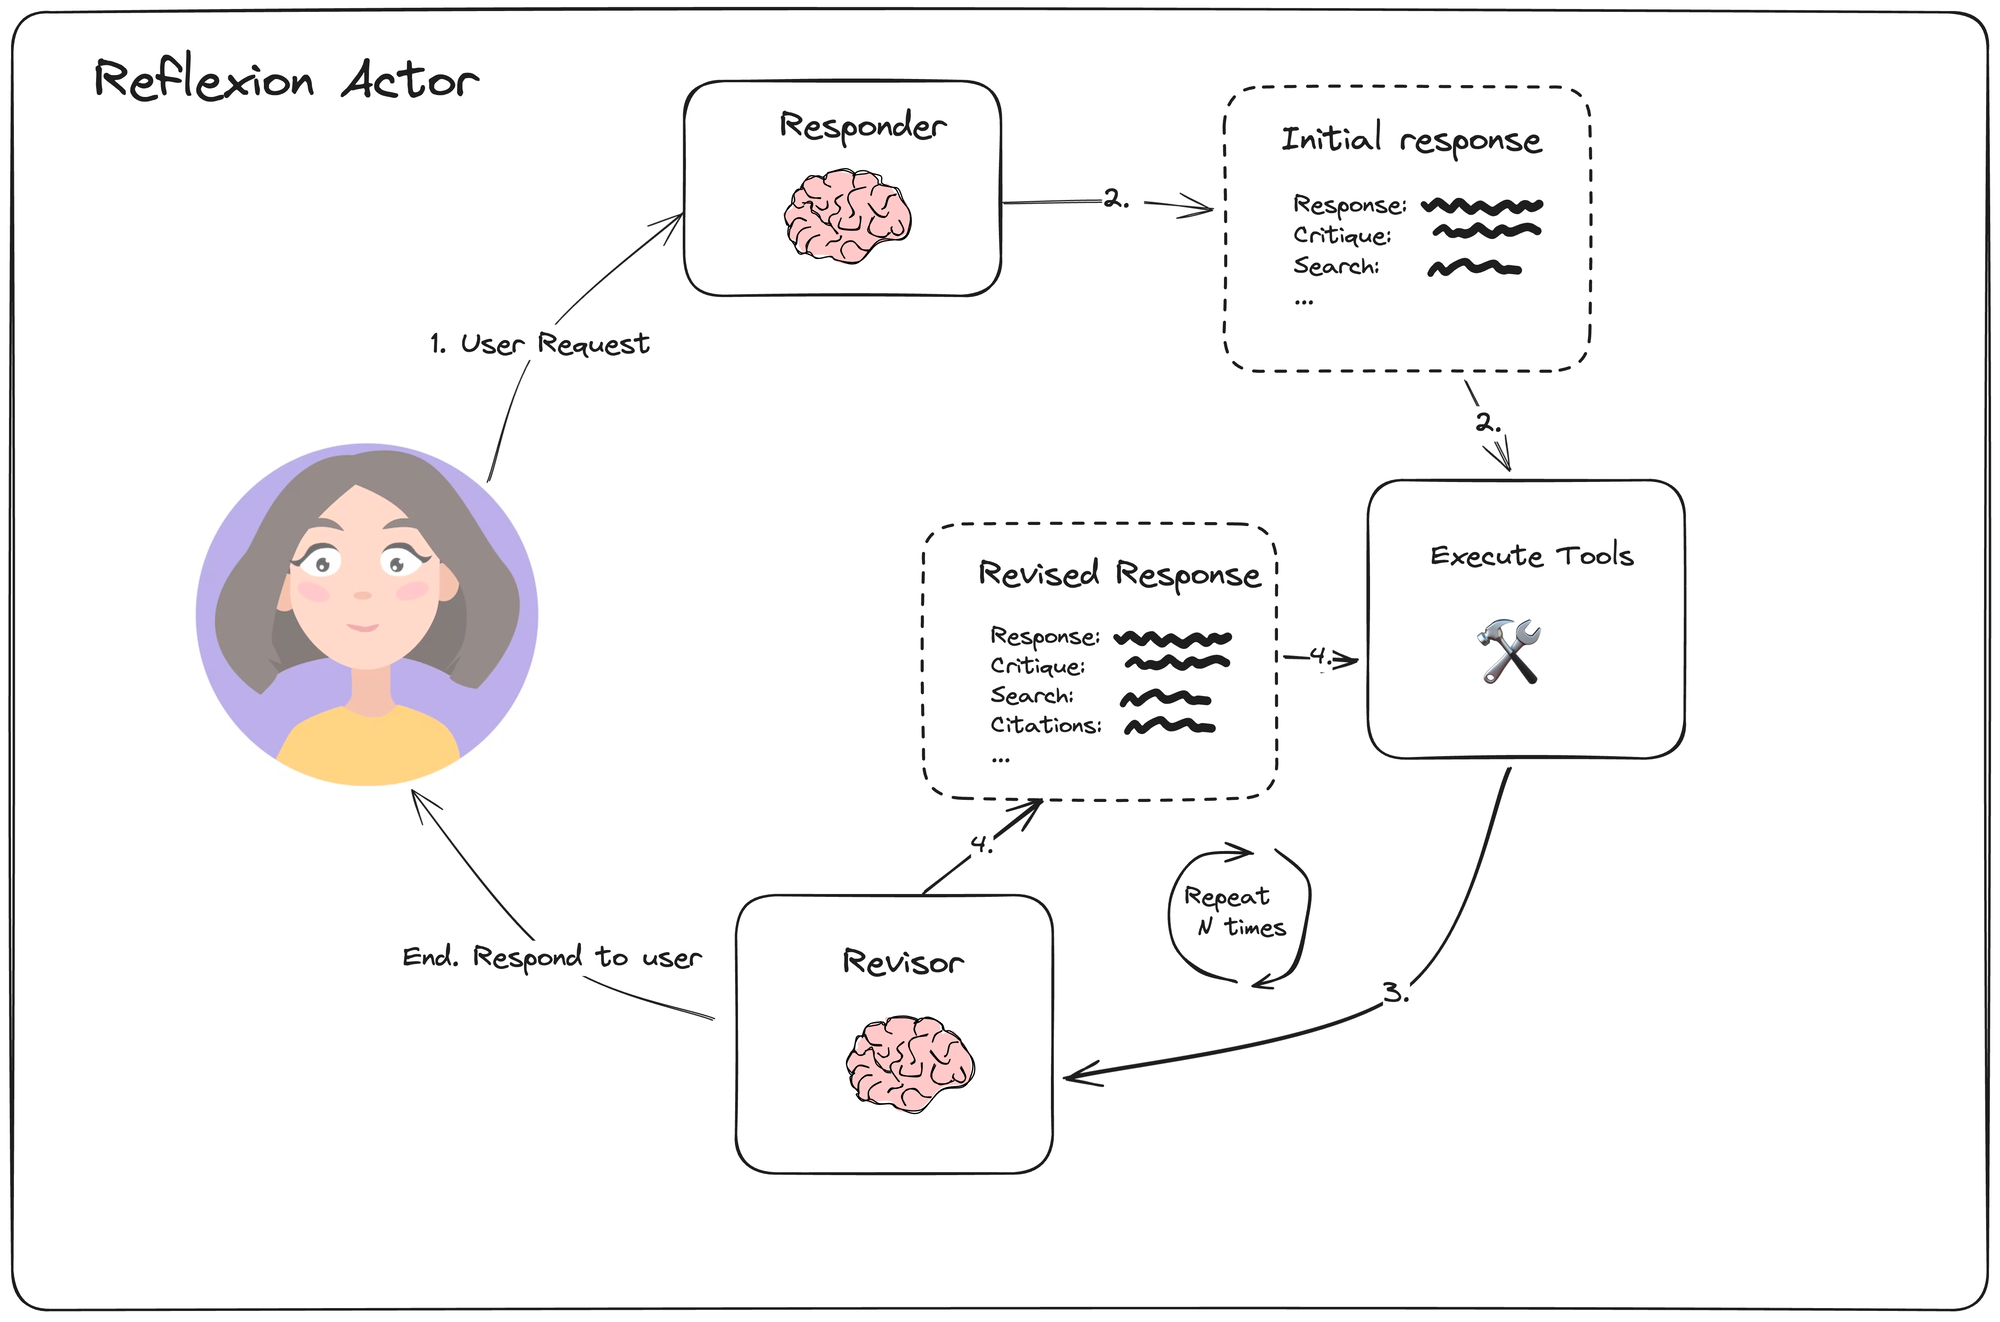

The paper outlines 3 main components:

1. Actor (agent) with self-reflection
2. External evaluator (task-specific, e.g. code compilation steps)
3. Episodic memory that stores the reflections from (1).

In their code, the last two components are very task-specific, so in this notebook, you will build the _actor_ in LangGraph.

To skip to the graph definition, see the [Construct Graph section](#Construct-Graph) below.

## Setup

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [1]:
%pip install -U --quiet  langgraph langchain_anthropic
%pip install -U --quiet tavily-python

In [1]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)

_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>   

### Define our LLM

In [2]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-sonnet-20240229")
# You could also use OpenAI or another provider
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

## Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections

We'll first define the tool execution context.

#### Construct tools

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

#### Initial responder

In [6]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [7]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

/Users/wfh/code/lc/langgraph/.venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatAnthropic.bind_tools` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [8]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond([HumanMessage(content=example_question)])

#### Revision

The second part of the actor is a revision step.

In [9]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [10]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised

AIMessage(content=[{'text': 'Okay, let me revise my answer using the ReviseAnswer tool:', 'type': 'text'}, {'id': 'toolu_01U5YD7JW3qXUBA7tVjGNF5G', 'input': {'answer': "Reflection is a crucial capability that enables artificial intelligence (AI) systems to achieve higher levels of performance, trustworthiness, and adaptability. By analyzing their own decisions, outputs, and outcomes, AI systems can identify strengths, weaknesses, biases, or errors in their models and algorithms. This self-analysis through reflection allows for continuous self-improvement and optimization [1].\n\nMoreover, reflection supports explainability in AI, providing transparency into the system's reasoning process and justifying how it arrived at a particular output [2]. This explainability is essential for building trust and accountability, especially in high-stakes domains.\n\nReflection also enables AI systems to re-evaluate whether their goals and priorities align with desired real-world outcomes as situatio

## Create Tool Node

Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.

In [11]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

## Construct Graph


Now we can wire all our components together.

In [12]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

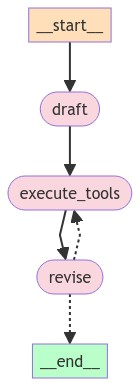

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================

[{'text': 'Here is my attempt at answering the question:', 'type': 'text'}, {'id': 'toolu_01YLQUcc7yyo1WwJoV5WQC2E', 'input': {'answer': 'The climate crisis poses an existential threat that requires urgent, far-reaching action on a global scale. To tackle this enormous challenge, a multi-pronged approach leveraging policy changes, technological innovations, and shifts in human behavior is needed.\n\nOn the policy front, governments should implement carbon pricing mechanisms like cap-and-trade systems or carbon taxes to disincentivize emissions and drive investment into clean energy sources. Strict regulations on polluting industries as well as subsidies and tax credits for renewable energy development can also accelerate the transition away from fossil fuels. Internation

## Conclusion

Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:
1. This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
2. The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
3. In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.